In [37]:
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 30

In [38]:
# 读取数据集
data = pd.read_csv(r'D:\python_project\model_data\房价预测回归模型\kc_house_data.csv')
# 删除不需要的列
data = data.drop(['id', 'date', 'zipcode', 'lat', 'long'], axis=1)
print(data.info())
# 查看异常值
# 可以使用箱线图、散点图等可视化方法来检测异常值

# 使用describe()方法查看数值型特征的统计信息，包括均值、标准差、最小值、最大值、分位数等
numeric_features = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot']
print(data[numeric_features].describe())

# 查看重复值
duplicate_rows = data[data.duplicated()]
print("重复值数量：", len(duplicate_rows))
# 去除重复值
data = data.drop_duplicates()
# 查看缺失值
missing_values = data.isnull().sum()
print("缺失值数量：")
print(missing_values)

# 如果发现缺失值，可以根据具体情况进行处理，例如删除含有缺失值的行或使用填充方法进行填充
# 删除含有缺失值的行
data = data.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  sqft_living15  21613 non-null  int64  
 15  sqft_lot15     21613 non-null  int64  
dtypes: float64(3), int64(13)
memory usage: 2.6 MB
None
              price      bedrooms     bathr

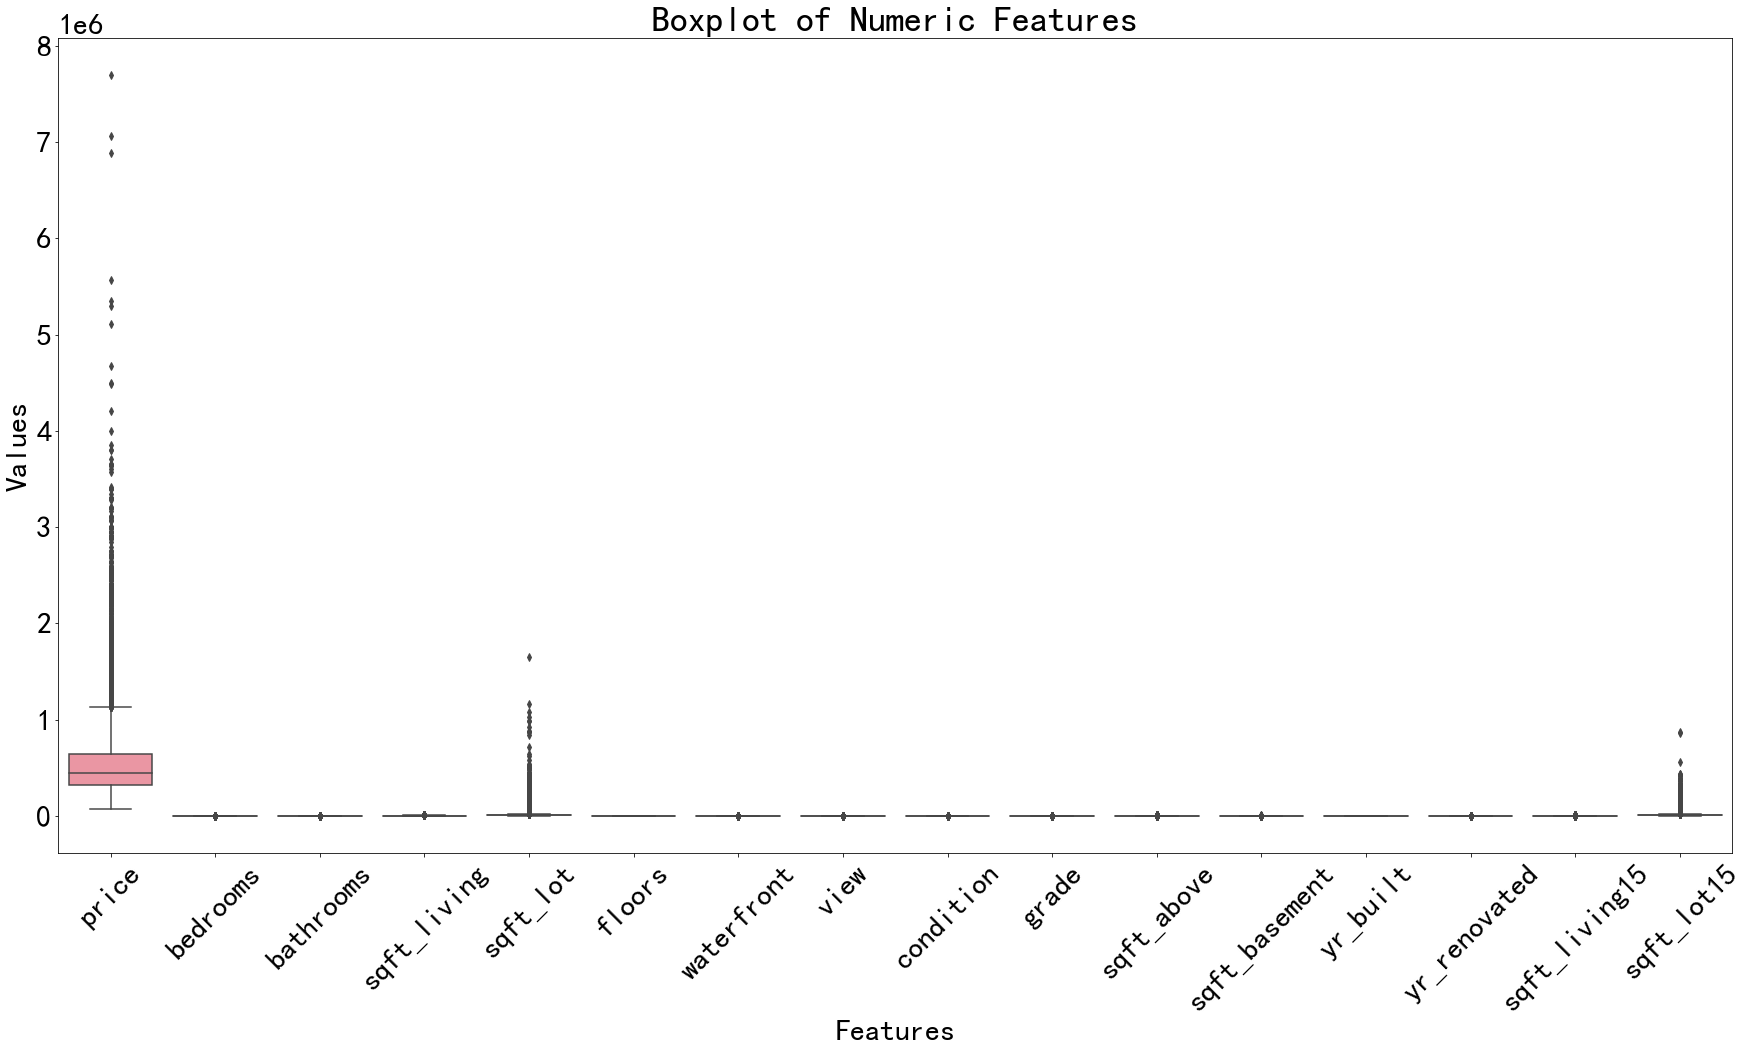

In [41]:
# 选择数值型变量
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
# 绘制数值型变量的箱线图
plt.figure(figsize=(30,15))
sns.boxplot(data=data[numeric_features])
plt.title('Boxplot of Numeric Features')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()

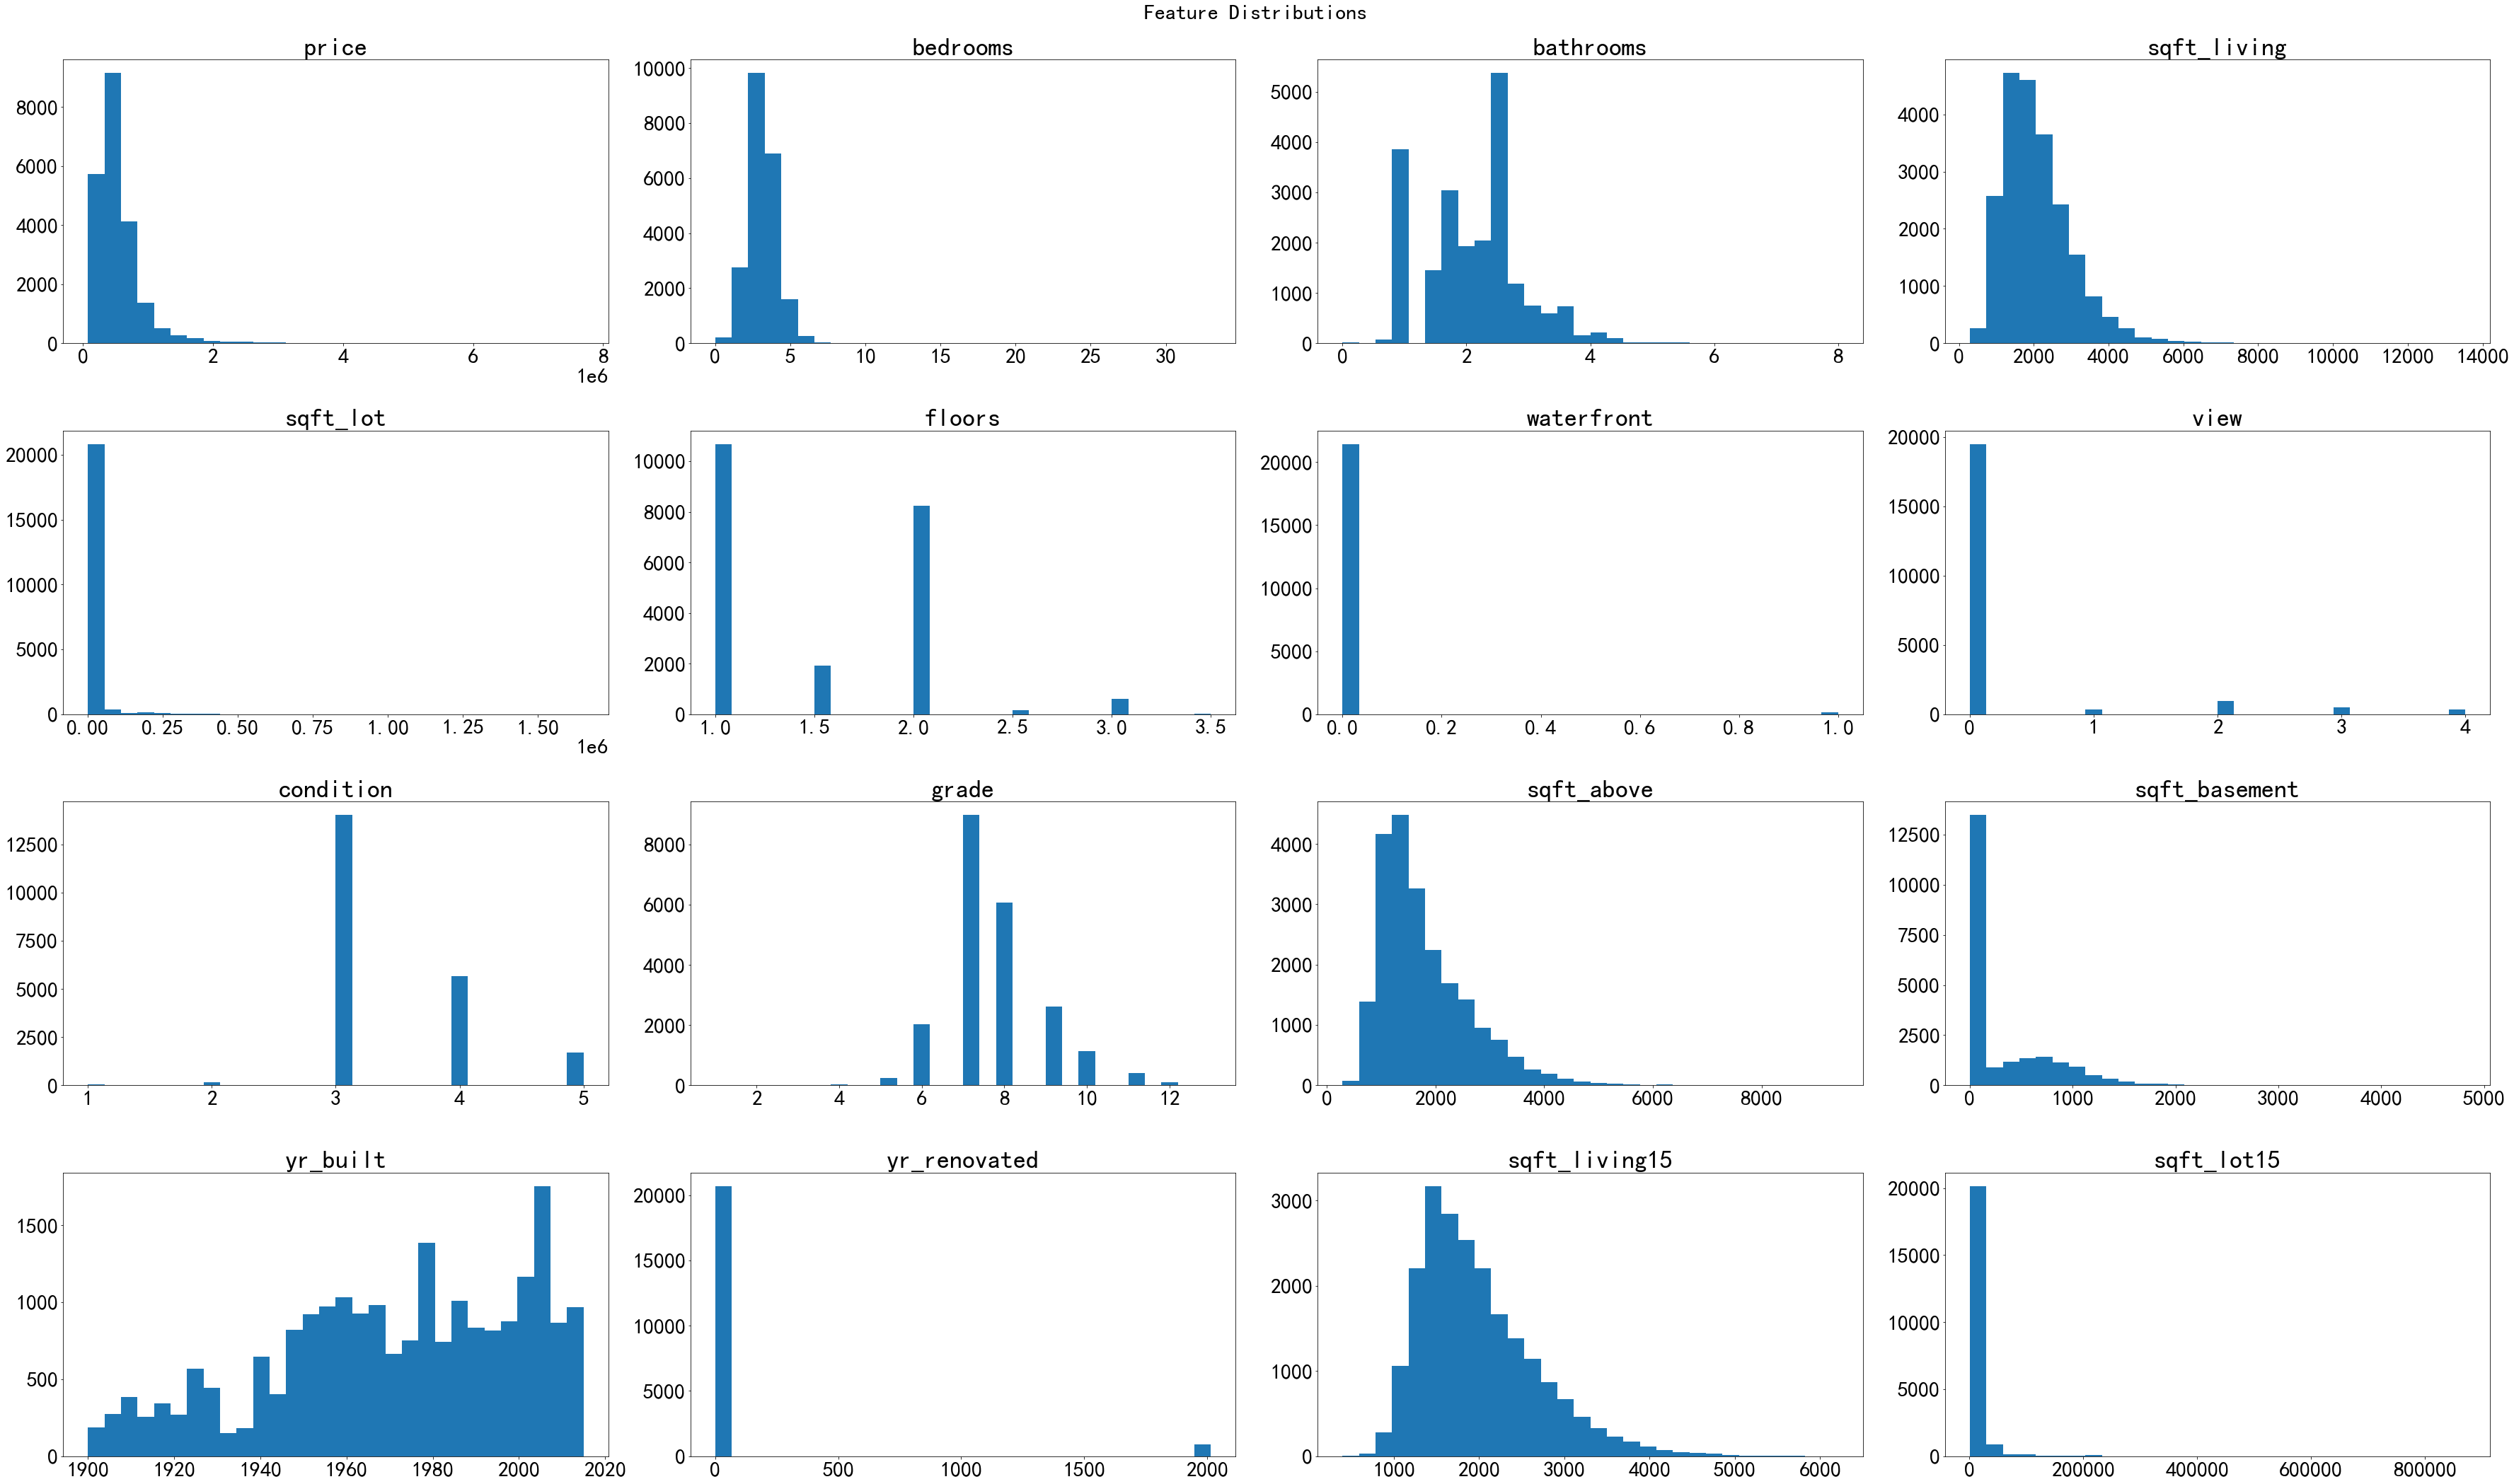

In [42]:
# 创建特征的直方分布子图
fig, axes = plt.subplots(4, 4, figsize=(50,30))
fig.suptitle('Feature Distributions', fontsize=30)

for i, ax in enumerate(axes.flat):
    feature = data.columns[i]
    ax.hist(data[feature], bins=30)
    ax.set_title(feature)

# 隐藏空的子图
if len(data.columns) < len(axes.flat):
    for j in range(len(data.columns), len(axes.flat)):
        axes.flat[j].axis('off')

plt.tight_layout()
plt.show()

In [43]:
# 选择要处理异常值的三列
columns = ['price', 'sqft_lot', 'sqft_lot15']

# 计算异常值的上下边界
for column in columns:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 将超出边界的异常值替换为边界值
    data[column] = data[column].clip(lower=lower_bound, upper=upper_bound)

# 打印处理后的数据集
print(data)

          price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0      221900.0         3       1.00         1180    5650.0     1.0   
1      538000.0         3       2.25         2570    7242.0     2.0   
2      180000.0         2       1.00          770   10000.0     1.0   
3      604000.0         4       3.00         1960    5000.0     1.0   
4      510000.0         3       2.00         1680    8080.0     1.0   
...         ...       ...        ...          ...       ...     ...   
21608  360000.0         3       2.50         1530    1131.0     3.0   
21609  400000.0         4       2.50         2310    5813.0     2.0   
21610  402101.0         2       0.75         1020    1350.0     2.0   
21611  400000.0         3       2.50         1600    2388.0     2.0   
21612  325000.0         2       0.75         1020    1076.0     2.0   

       waterfront  view  condition  grade  sqft_above  sqft_basement  \
0               0     0          3      7        1180              0   
1  

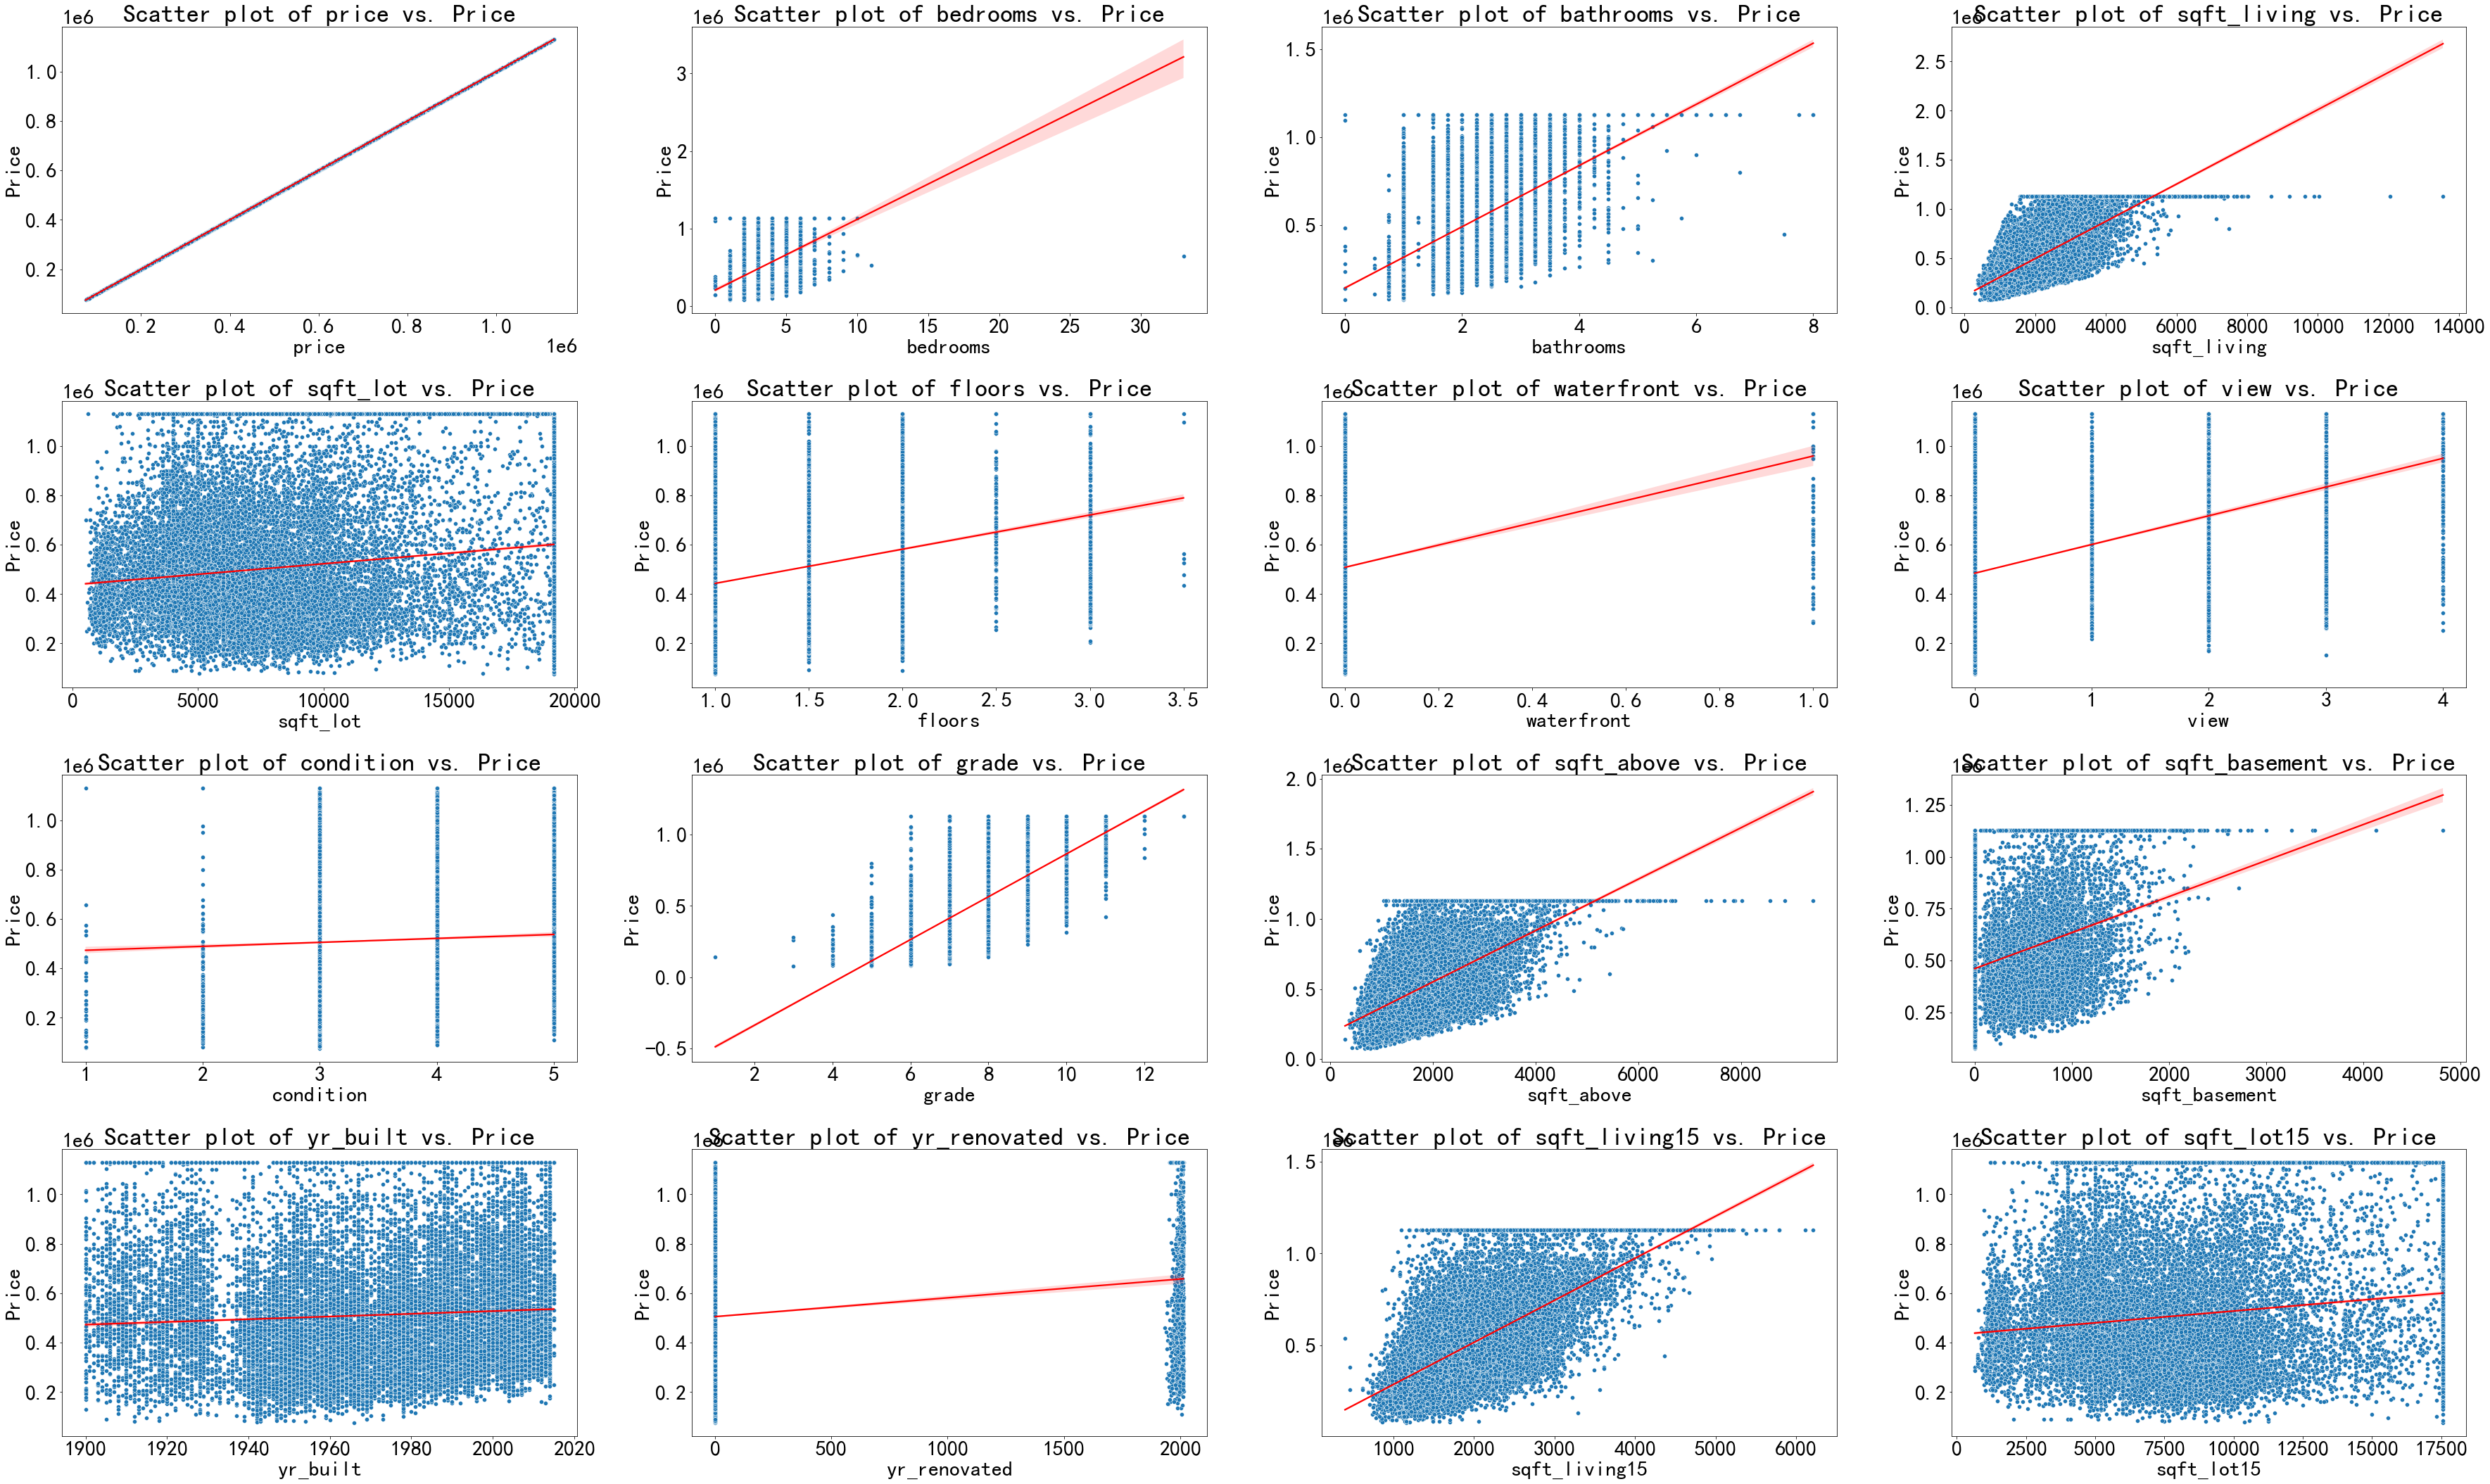

In [45]:
# 绘制数值型变量与房价的散点图
fig, axes = plt.subplots(4,4, figsize=(50,30))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    sns.scatterplot(data=data, x=feature, y='price', ax=axes[i])
    sns.regplot(data=data, x=feature, y='price', ax=axes[i], scatter=False, color='red')
    axes[i].set_title(f'Scatter plot of {feature} vs. Price')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Price')

plt.tight_layout()
plt.show()


In [46]:

# 提取特征和目标变量
X = data.drop('price', axis=1)
y = data['price']


In [47]:
# 数据归一化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()


In [48]:

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.preprocessing import StandardScaler
# 实例化LASSO回归模型
lasso_model = Lasso(alpha=0.1)  # alpha是正则化强度

# 拟合LASSO模型
lasso_model.fit(X_train, y_train)

# 实例化Ridge回归模型
ridge_model = Ridge(alpha=0.5)  # alpha是正则化强度

# 拟合Ridge模型
ridge_model.fit(X_train, y_train)

# 在测试集上进行预测
lasso_y_pred = lasso_model.predict(X_test)
ridge_y_pred = ridge_model.predict(X_test)

# 评估模型性能
lasso_mse = mean_squared_error(y_test, lasso_y_pred)
lasso_rmse = np.sqrt(lasso_mse)
lasso_mae = mean_absolute_error(y_test, lasso_y_pred)
lasso_mvs = explained_variance_score(y_test, lasso_y_pred)

ridge_mse = mean_squared_error(y_test, ridge_y_pred)
ridge_rmse = np.sqrt(ridge_mse)
ridge_mae = mean_absolute_error(y_test, ridge_y_pred)
ridge_mvs = explained_variance_score(y_test, ridge_y_pred)

# 输出评估结果
print("LASSO Regression:")
print("Mean Squared Error (MSE):", lasso_mse)
print("Root Mean Squared Error (RMSE):", lasso_rmse)
print("Mean Absolute Error (MAE):", lasso_mae)
print("Explained Variance Score (MVS):", lasso_mvs)
print()
print("Ridge Regression:")
print("Mean Squared Error (MSE):", ridge_mse)
print("Root Mean Squared Error (RMSE):", ridge_rmse)
print("Mean Absolute Error (MAE):", ridge_mae)
print("Explained Variance Score (MVS):", ridge_mvs)


LASSO Regression:
Mean Squared Error (MSE): 0.3950681961756961
Root Mean Squared Error (RMSE): 0.6285445061216398
Mean Absolute Error (MAE): 0.4900453946030875
Explained Variance Score (MVS): 0.613943557812197

Ridge Regression:
Mean Squared Error (MSE): 0.33507444799992797
Root Mean Squared Error (RMSE): 0.5788561548432632
Mean Absolute Error (MAE): 0.4437822958676213
Explained Variance Score (MVS): 0.6725164406367837


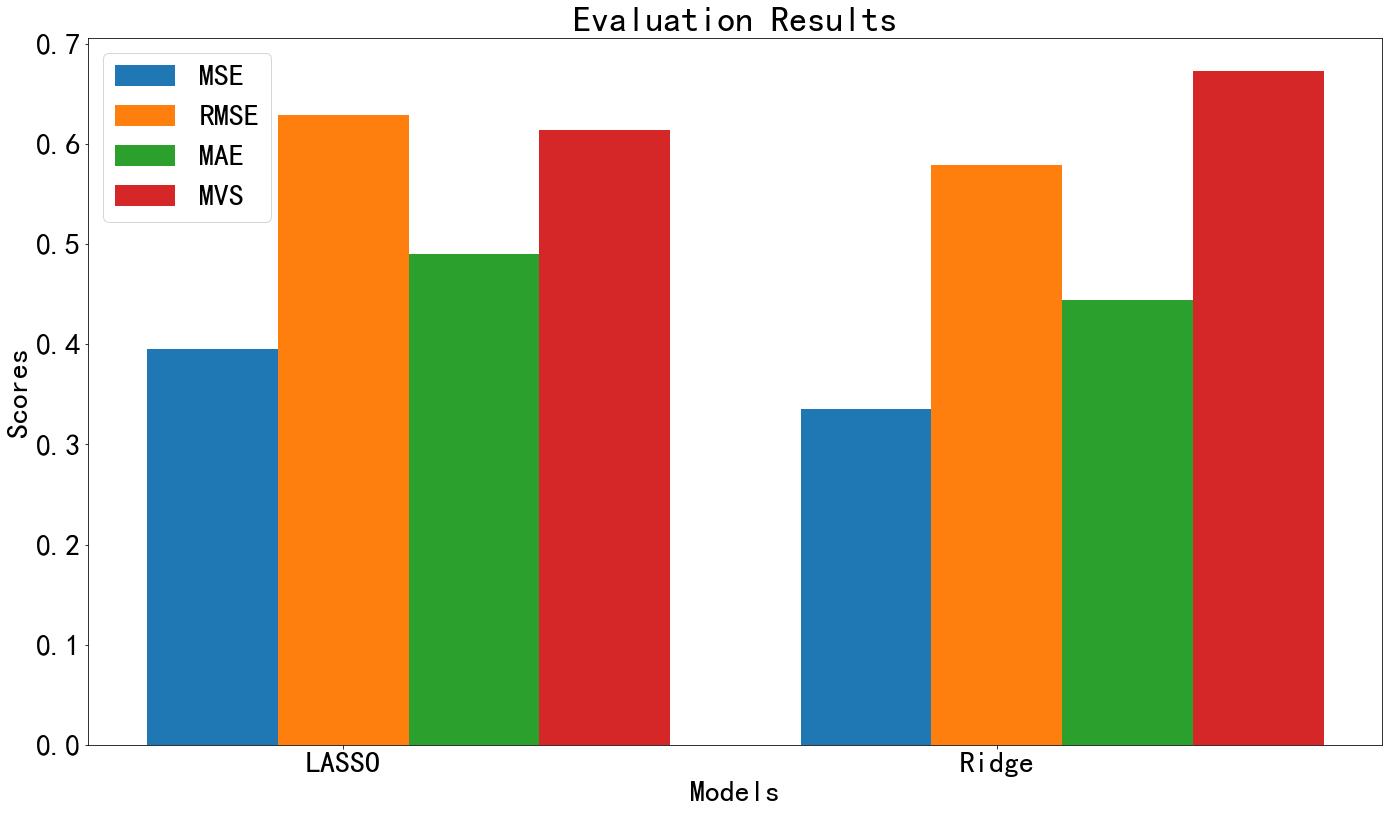

In [50]:
# 创建评估结果字典
eval_results = {
    'LASSO': {'MSE': lasso_mse, 'RMSE': lasso_rmse, 'MAE': lasso_mae, 'MVS': lasso_mvs},
    'Ridge': {'MSE': ridge_mse, 'RMSE': ridge_rmse, 'MAE': ridge_mae, 'MVS': ridge_mvs}
}

# 提取评估指标和模型名称
metrics = list(eval_results['LASSO'].keys())
models = list(eval_results.keys())

# 绘制柱状图
plt.figure(figsize=(20,12))
for i, metric in enumerate(metrics):
    metric_scores = [eval_results[model][metric] for model in models]
    plt.bar(np.arange(len(models)) + i * 0.2, metric_scores, width=0.2, label=metric)

plt.xticks(np.arange(len(models)) + 0.2, models)
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Evaluation Results')
plt.legend()

# 添加数据标签
# for i, metric in enumerate(metrics):
#     for j, model in enumerate(models):
#         score = eval_results[model][metric]
#         plt.text(j + i * 0.2, score + 0.01, f'{score:.3f}', ha='center')

plt.tight_layout()
plt.show()

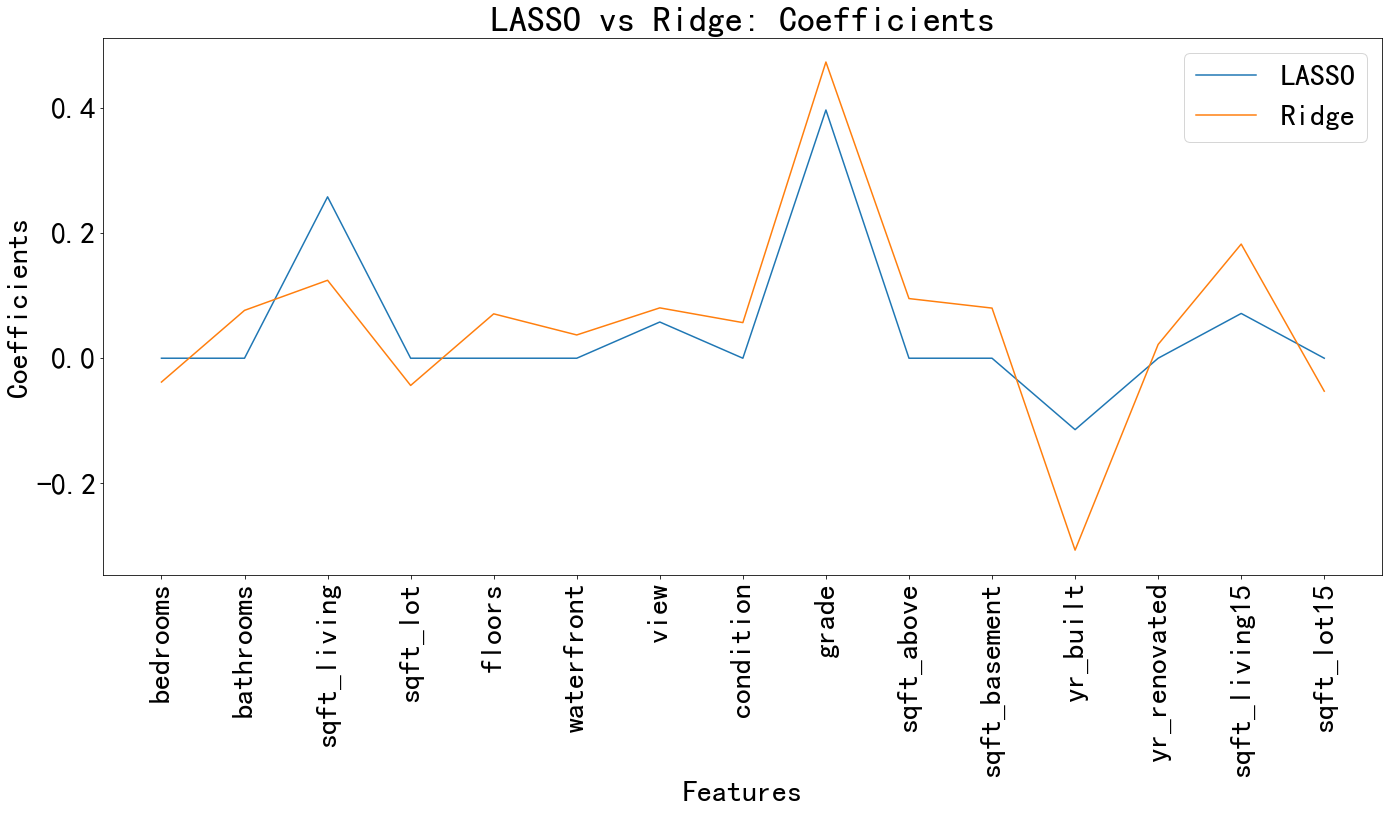

In [51]:
# 可视化训练过程
lasso_coefs = lasso_model.coef_
ridge_coefs = ridge_model.coef_

plt.figure(figsize=(20,12))
plt.plot(range(len(lasso_coefs)), lasso_coefs, label='LASSO')
plt.plot(range(len(ridge_coefs)), ridge_coefs, label='Ridge')
plt.xticks(range(len(X.columns)), X.columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('LASSO vs Ridge: Coefficients')
plt.legend()
plt.tight_layout()
plt.show()

In [52]:
# 实例化LASSO回归模型
lasso_model = Lasso()

# 设置超参数候选范围
lasso_params = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}

# 使用网格搜索进行超参数优化
lasso_grid = GridSearchCV(estimator=lasso_model, param_grid=lasso_params, cv=5)
lasso_grid.fit(X_train, y_train)

# 获取最佳超参数和模型
best_lasso_alpha = lasso_grid.best_params_['alpha']
best_lasso_model = lasso_grid.best_estimator_

# 实例化Ridge回归模型
ridge_model = Ridge()

# 设置超参数候选范围
ridge_params = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}

# 使用网格搜索进行超参数优化
ridge_grid = GridSearchCV(estimator=ridge_model, param_grid=ridge_params, cv=100)
ridge_grid.fit(X_train, y_train)

# 获取最佳超参数和模型
best_ridge_alpha = ridge_grid.best_params_['alpha']
best_ridge_model = ridge_grid.best_estimator_

# 在测试集上进行预测
lasso_y_pred = best_lasso_model.predict(X_test)
ridge_y_pred = best_ridge_model.predict(X_test)


Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

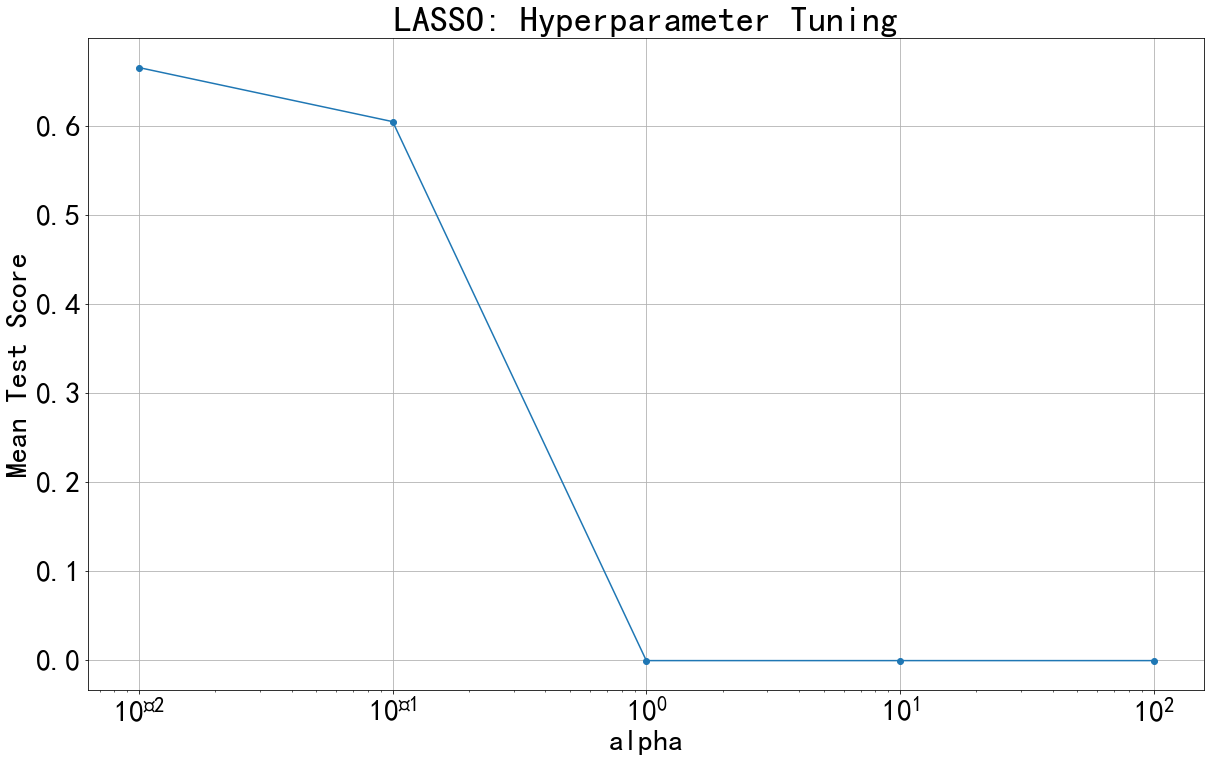

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.


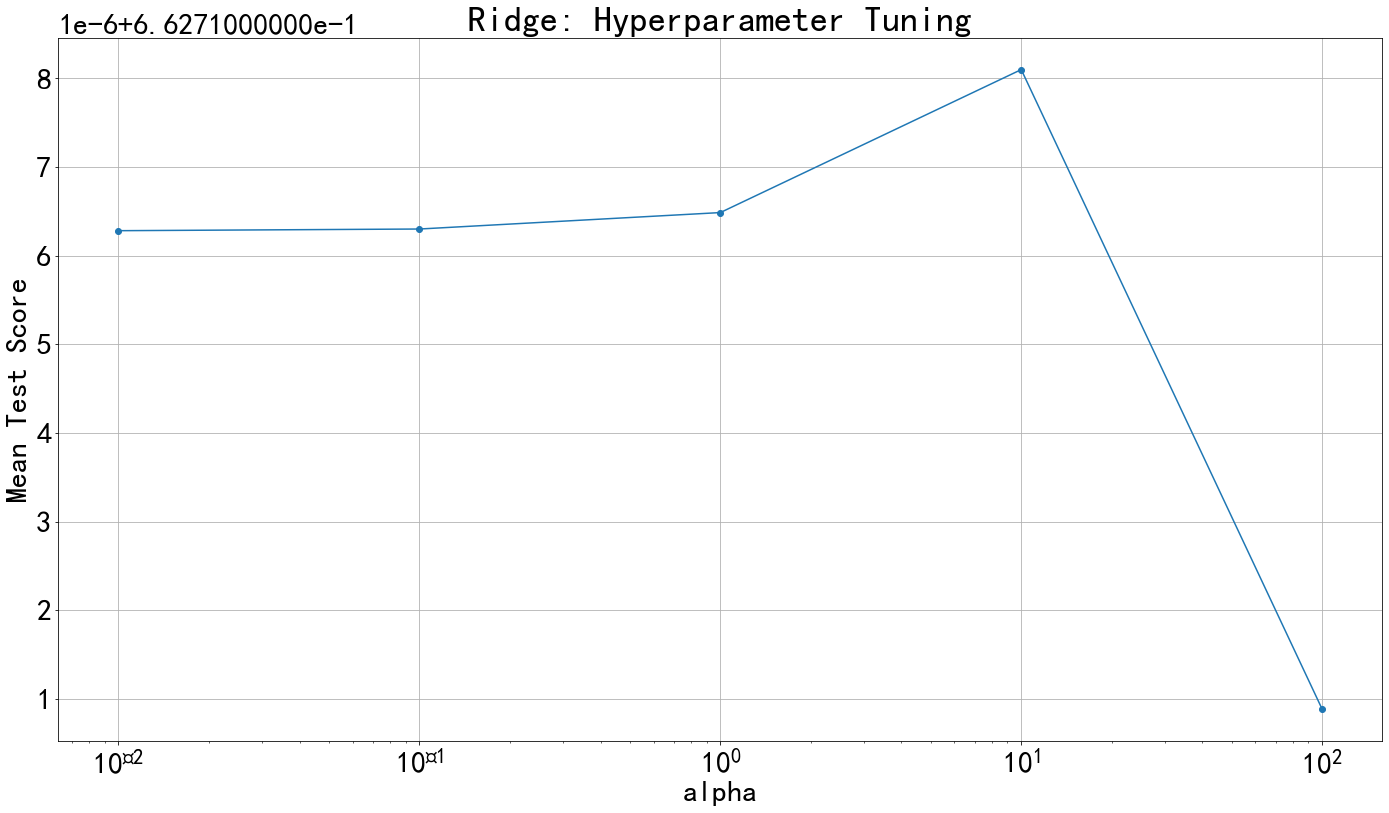

In [53]:
# 可视化超参数优化过程
lasso_cv_results = pd.DataFrame(lasso_grid.cv_results_)
ridge_cv_results = pd.DataFrame(ridge_grid.cv_results_)

plt.figure(figsize=(20,12))
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_test_score'], marker='o')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Mean Test Score')
plt.title('LASSO: Hyperparameter Tuning')
plt.grid(True)

plt.figure(figsize=(20,12))
plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_test_score'], marker='o')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Mean Test Score')
plt.title('Ridge: Hyperparameter Tuning')
plt.grid(True)

plt.tight_layout()
plt.show()

LASSO Regression:
Mean Squared Error (MSE): 0.33624288017776066
Root Mean Squared Error (RMSE): 0.5798645360580009
Mean Absolute Error (MAE): 0.4448629874272186
Explained Variance Score (MVS): 0.6713787633848962

Ridge Regression:
Mean Squared Error (MSE): 0.3350638355292925
Root Mean Squared Error (RMSE): 0.5788469880109013
Mean Absolute Error (MAE): 0.44378738631041625
Explained Variance Score (MVS): 0.6725267654881094


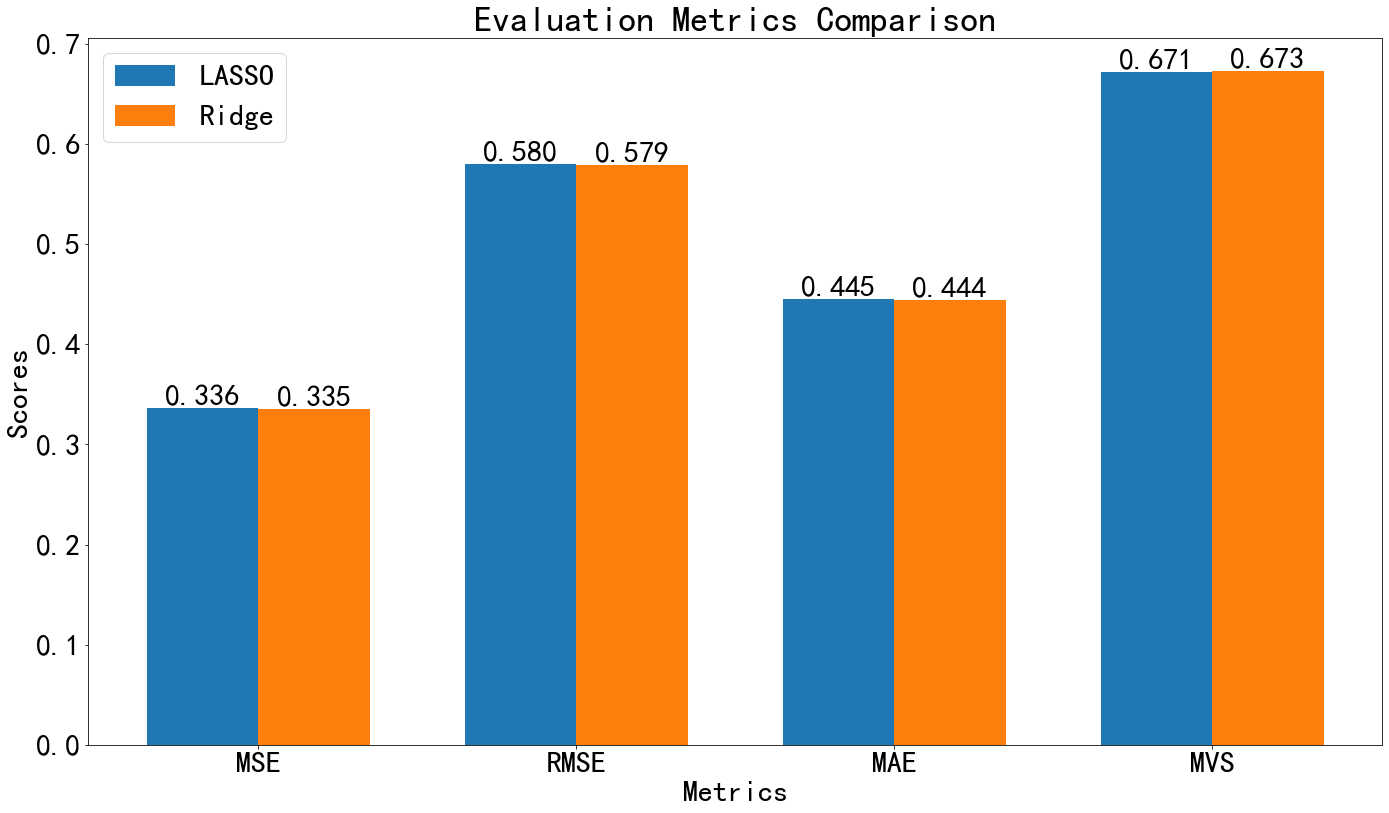

In [54]:
# 评估模型性能
lasso_mse = mean_squared_error(y_test, lasso_y_pred)
lasso_rmse = np.sqrt(lasso_mse)
lasso_mae = mean_absolute_error(y_test, lasso_y_pred)
lasso_mvs = explained_variance_score(y_test, lasso_y_pred)

ridge_mse = mean_squared_error(y_test, ridge_y_pred)
ridge_rmse = np.sqrt(ridge_mse)
ridge_mae = mean_absolute_error(y_test, ridge_y_pred)
ridge_mvs = explained_variance_score(y_test, ridge_y_pred)

# 输出评估结果
print("LASSO Regression:")
print("Mean Squared Error (MSE):", lasso_mse)
print("Root Mean Squared Error (RMSE):", lasso_rmse)
print("Mean Absolute Error (MAE):", lasso_mae)
print("Explained Variance Score (MVS):", lasso_mvs)
print()

print("Ridge Regression:")
print("Mean Squared Error (MSE):", ridge_mse)
print("Root Mean Squared Error (RMSE):", ridge_rmse)
print("Mean Absolute Error (MAE):", ridge_mae)
print("Explained Variance Score (MVS):", ridge_mvs)

# 可视化评估指标
labels = ['MSE', 'RMSE', 'MAE', 'MVS']
lasso_scores = [lasso_mse, lasso_rmse, lasso_mae, lasso_mvs]
ridge_scores = [ridge_mse, ridge_rmse, ridge_mae, ridge_mvs]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(20,12))
rects1 = ax.bar(x - width/2, lasso_scores, width, label='LASSO')
rects2 = ax.bar(x + width/2, ridge_scores, width, label='Ridge')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Evaluation Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# 添加数据标签
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()